In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=55504828fc3bfe8366fe76ab9e4e345ae0e5bb2e713016ad6dd1e93ce11f1faa
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
import pandas as pd
from lifelines import CoxPHFitter

# Load the clinical dataset
df = pd.read_csv('/content/sample_data/final_dataset_with_clinical (1).csv')
# Load gene panel
gene_panel = pd.read_excel('/content/sample_data/gene_panel_update.xlsx')
gene_list = gene_panel.columns.tolist() if gene_panel.shape[1] > 1 else gene_panel.iloc[:, 0].dropna().unique().tolist()

# Filter genes present in the dataset
available_genes = [gene for gene in gene_list if gene in df.columns]

<ipython-input-4-f2b2cf153336>:5: DtypeWarning: Columns (150) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/sample_data/final_dataset_with_clinical (1).csv')


In [ ]:

# List of genes want to check
genes_to_check = ['AKT1', 'AXIN1', 'BRAF', 'CCND1', 'CDK6']

# Loop through each gene and create a new _altered column
for gene in genes_to_check:
    if gene in df.columns:
        df[gene + '_altered'] = df[gene].apply(lambda x: 1 if pd.notna(x) and str(x).strip().lower() != 'none' else 0)

# Preview counts of alterations
for gene in genes_to_check:
    col = gene + '_altered'
    if col in df.columns:
        print(f"{gene}: {df[col].sum()} alterations")


AKT1: 118 alterations
BRAF: 667 alterations
CCND1: 92 alterations
CDK6: 58 alterations


In [ ]:
results = []
for cancer_type in df['cancer_type'].dropna().unique():
    df_cancer = df[df['cancer_type'] == cancer_type].copy()
    altered_cols = {}

    for gene in available_genes:
        altered_col = f'{gene}_altered'
        altered_cols[altered_col] = df_cancer[gene].apply(lambda x: 1 if pd.notna(x) and str(x).strip().lower() != 'none' else 0)

    df_cancer = pd.concat([df_cancer, pd.DataFrame(altered_cols, index=df_cancer.index)], axis=1)

    for gene in available_genes:
        altered_col = f'{gene}_altered'

        if altered_col not in df_cancer.columns:
            continue

        try:
            cph = CoxPHFitter()
            cox_df = df_cancer[[altered_col, 'OS.time', 'OS']].dropna()
            if cox_df[altered_col].nunique() < 2:
                continue

            cph.fit(cox_df, duration_col='OS.time', event_col='OS')
            summary = cph.summary.loc[altered_col]


            if summary['p'] < 0.05:
                results.append({
                    'Cancer_Type': cancer_type,
                    'Gene': gene,
                    'p-value': summary['p'],
                    'HR': summary['exp(coef)'],
                    'Lower 95% CI': summary['exp(coef) lower 95%'],
                    'Upper 95% CI': summary['exp(coef) upper 95%']
                })

        except Exception as e:
            print(f"Model failed for {gene} in {cancer_type} due to: {e}")

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column AKT1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'AKT1_altered'].var())
>>> print(df.loc[~events, 'AKT1_altered'].var())

A very low variance means that the column AKT1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.124. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complet

Model failed for CSF1R in ACC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column HMGCR_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'HMGCR_altered'].var())
>>> print(df.loc[~events, 'HMGCR_altered'].var())

A very low variance means that the column HMGCR_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.151. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for KDR in ACC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for LDHA in ACC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column MAPK1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'MAPK1_altered'].var())
>>> print(df.loc[~events, 'MAPK1_altered'].var())

A very low variance means that the column MAPK1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.151. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for TAZ in ACC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ULK1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'ULK1_altered'].var())
>>> print(df.loc[~events, 'ULK1_altered'].var())

A very low variance means that the column ULK1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.151. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complet

Model failed for HMGCR in ESCA due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.
Model failed for IL1R1 in ESCA due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column KDR_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'KDR_altered'].var())
>>> print(df.loc[~events, 'KDR_altered'].var())

A very low variance means that the column KDR_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.129. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete se

Model failed for ACACA in SARC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1729: RuntimeWarning: invalid value encountered in multiply
  a1 = e

Model failed for CCND1 in SARC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CHEK1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CHEK1_altered'].var())
>>> print(df.loc[~events, 'CHEK1_altered'].var())

A very low variance means that the column CHEK1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CHEK2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the follow

Model failed for CHEK1 in SARC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CSF2RA_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CSF2RA_altered'].var())
>>> print(df.loc[~events, 'CSF2RA_altered'].var())

A very low variance means that the column CSF2RA_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.143. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or

Model failed for DAAM1 in SARC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column HK2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'HK2_altered'].var())
>>> print(df.loc[~events, 'HK2_altered'].var())

A very low variance means that the column HK2_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.143. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete se

Model failed for KRAS in SARC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column NOTCH1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'NOTCH1_altered'].var())
>>> print(df.loc[~events, 'NOTCH1_altered'].var())

A very low variance means that the column NOTCH1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.143. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or

Model failed for SMAD4 in SARC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for SOX9 in SARC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1729: RuntimeWarning: invalid value encountered in multiply
  a1 = e

Model failed for CCND1 in CESC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CDH1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CDH1_altered'].var())
>>> print(df.loc[~events, 'CDH1_altered'].var())

A very low variance means that the column CDH1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.110. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complet

Model failed for CSF2RA in CESC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column DAAM2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'DAAM2_altered'].var())
>>> print(df.loc[~events, 'DAAM2_altered'].var())

A very low variance means that the column DAAM2_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.167. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for MAP2K3 in KIRC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column RB1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'RB1_altered'].var())
>>> print(df.loc[~events, 'RB1_altered'].var())

A very low variance means that the column RB1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Model failed for RB1 in KIRC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column SLC16A1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'SLC16A1_altered'].var())
>>> print(df.loc[~events, 'SLC16A1_altered'].var())

A very low variance means that the column SLC16A1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.110. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearit

Model failed for SLC2A1 in KIRC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column TNFRSF1A_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'TNFRSF1A_altered'].var())
>>> print(df.loc[~events, 'TNFRSF1A_altered'].var())

A very low variance means that the column TNFRSF1A_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.126. This may imply non-unique solutions to the maximum likelihood. Perhaps there is colline

Model failed for TRAF4 in SKCM due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column YAP1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'YAP1_altered'].var())
>>> print(df.loc[~events, 'YAP1_altered'].var())

A very low variance means that the column YAP1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ACACA_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following 

Model failed for YAP1 in SKCM due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ACACB_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'ACACB_altered'].var())
>>> print(df.loc[~events, 'ACACB_altered'].var())

A very low variance means that the column ACACB_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column ACACB_altered has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/ques

Model failed for TLR1 in UCS due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: in

Model failed for CHEK1 in BRCA due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column DAAM1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'DAAM1_altered'].var())
>>> print(df.loc[~events, 'DAAM1_altered'].var())

A very low variance means that the column DAAM1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.104. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for EGLN2 in BRCA due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column KIT_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'KIT_altered'].var())
>>> print(df.loc[~events, 'KIT_altered'].var())

A very low variance means that the column KIT_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.110. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete se

Model failed for NDRG3 in BRCA due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column RET_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'RET_altered'].var())
>>> print(df.loc[~events, 'RET_altered'].var())

A very low variance means that the column RET_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.125. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete se

Model failed for RHEB in BRCA due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for RPS6KB1 in BRCA due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1729: RuntimeWarning: invalid value encountered in multiply
  a1 = e

Model failed for SOX4 in BRCA due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ACACA_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'ACACA_altered'].var())
>>> print(df.loc[~events, 'ACACA_altered'].var())

A very low variance means that the column ACACA_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.147. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for MTOR in UVM due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ULK1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'ULK1_altered'].var())
>>> print(df.loc[~events, 'ULK1_altered'].var())

A very low variance means that the column ULK1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column ULK1_altered has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions

Model failed for AKT1 in OV due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: in

Model failed for FGFR1 in OV due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: in

Model failed for MAPK1 in OV due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: in

Model failed for RHOA in OV due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ACACB_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'ACACB_altered'].var())
>>> print(df.loc[~events, 'ACACB_altered'].var())

A very low variance means that the column ACACB_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CTNNB1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the follo

Model failed for ACACB in MESO due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column FGFR1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'FGFR1_altered'].var())
>>> print(df.loc[~events, 'FGFR1_altered'].var())

A very low variance means that the column FGFR1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column FGFR1_altered has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/ques

Model failed for PTEN in MESO due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for RHOA in MESO due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column TSC1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'TSC1_altered'].var())
>>> print(df.loc[~events, 'TSC1_altered'].var())

A very low variance means that the column TSC1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column TSC1_altered has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions

Model failed for ACLY in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for ACVR2A in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for CDK2 in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CDH1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CDH1_altered'].var())
>>> print(df.loc[~events, 'CDH1_altered'].var())

A very low variance means that the column CDH1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.200. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complet

Model failed for CHEK2 in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for HK2 in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column LATS2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'LATS2_altered'].var())
>>> print(df.loc[~events, 'LATS2_altered'].var())

A very low variance means that the column LATS2_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.200. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for PFKM in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for PTEN in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for RET in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for SREBF1 in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column TRAF4_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'TRAF4_altered'].var())
>>> print(df.loc[~events, 'TRAF4_altered'].var())

A very low variance means that the column TRAF4_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.200. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for ZHX2 in CHOL due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CDK4_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CDK4_altered'].var())
>>> print(df.loc[~events, 'CDK4_altered'].var())

A very low variance means that the column CDK4_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.103. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complet

Model failed for BRCA1 in PRAD due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CDKN1B_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CDKN1B_altered'].var())
>>> print(df.loc[~events, 'CDKN1B_altered'].var())

A very low variance means that the column CDKN1B_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.171. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or

Model failed for CHEK1 in PRAD due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CTNNB1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CTNNB1_altered'].var())
>>> print(df.loc[~events, 'CTNNB1_altered'].var())

A very low variance means that the column CTNNB1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.207. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or

Model failed for JAK1 in PRAD due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1530: LinAlgWarning: Ill-conditioned matrix (rcond=0): result may not be accurate.
  inv_h_dot_g_T = spsolve(-h, g, assume_a="pos", check_finite=False)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py

Model failed for MET in PRAD due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column PDGFRA_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'PDGFRA_altered'].var())
>>> print(df.loc[~events, 'PDGFRA_altered'].var())

A very low variance means that the column PDGFRA_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.122. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or

Model failed for RAF1 in PRAD due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column SETD2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'SETD2_altered'].var())
>>> print(df.loc[~events, 'SETD2_altered'].var())

A very low variance means that the column SETD2_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.184. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for STK3 in PRAD due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column TSC2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'TSC2_altered'].var())
>>> print(df.loc[~events, 'TSC2_altered'].var())

A very low variance means that the column TSC2_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.156. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complet

Model failed for VHL in PRAD due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ATR_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'ATR_altered'].var())
>>> print(df.loc[~events, 'ATR_altered'].var())

A very low variance means that the column ATR_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.137. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete se

Model failed for EGFR in PCPG due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column FGFR1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'FGFR1_altered'].var())
>>> print(df.loc[~events, 'FGFR1_altered'].var())

A very low variance means that the column FGFR1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.192. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for SETD2 in PCPG due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CHEK2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CHEK2_altered'].var())
>>> print(df.loc[~events, 'CHEK2_altered'].var())

A very low variance means that the column CHEK2_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.108. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for ATR in THYM due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CTNNB1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CTNNB1_altered'].var())
>>> print(df.loc[~events, 'CTNNB1_altered'].var())

A very low variance means that the column CTNNB1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.204. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or

Model failed for PFKM in THYM due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for SETD2 in THYM due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for SLC16A1 in THYM due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for SLC2A1 in THYM due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/la

/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column SOX4_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'SOX4_altered'].var())
>>> print(df.loc[~events, 'SOX4_altered'].var())

A very low variance means that the column SOX4_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.204. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complet

Model failed for CCNE1 in LIHC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.
Model failed for CDK4 in LIHC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column DAAM2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'DAAM2_altered'].var())
>>> print(df.loc[~events, 'DAAM2_altered'].var())

A very low variance means that the column DAAM2_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.127. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for GSK3B in LIHC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for HIF1A in LIHC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column MAP2K1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'MAP2K1_altered'].var())
>>> print(df.loc[~events, 'MAP2K1_altered'].var())

A very low variance means that the column MAP2K1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Model failed for MAP2K1 in LIHC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: invalid value encountered in multiply
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: in

Model failed for MYC in LIHC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column NOTCH1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'NOTCH1_altered'].var())
>>> print(df.loc[~events, 'NOTCH1_altered'].var())

A very low variance means that the column NOTCH1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.149. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or

Model failed for PRKAA2 in LIHC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column STK11_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'STK11_altered'].var())
>>> print(df.loc[~events, 'STK11_altered'].var())

A very low variance means that the column STK11_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column TGFBR2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the follo

Model failed for STK11 in LIHC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.
Model failed for TGFBR2 in LIHC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CDK6_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'CDK6_altered'].var())
>>> print(df.loc[~events, 'CDK6_altered'].var())

A very low variance means that the column CDK6_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.126. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complet

Model failed for SOX17 in READ due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column STAT5A_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'STAT5A_altered'].var())
>>> print(df.loc[~events, 'STAT5A_altered'].var())

A very low variance means that the column STAT5A_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.121. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or

Model failed for ACLY in KICH due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column LATS2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'LATS2_altered'].var())
>>> print(df.loc[~events, 'LATS2_altered'].var())

A very low variance means that the column LATS2_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.533. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for YAP1 in KICH due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ACACB_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'ACACB_altered'].var())
>>> print(df.loc[~events, 'ACACB_altered'].var())

A very low variance means that the column ACACB_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.242. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for CCND2 in DLBC due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column DAAM2_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'DAAM2_altered'].var())
>>> print(df.loc[~events, 'DAAM2_altered'].var())

A very low variance means that the column DAAM2_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.174. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for KRAS in DLBC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column NF1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'NF1_altered'].var())
>>> print(df.loc[~events, 'NF1_altered'].var())

A very low variance means that the column NF1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.292. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete se

Model failed for SOX17 in DLBC due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column ACACA_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'ACACA_altered'].var())
>>> print(df.loc[~events, 'ACACA_altered'].var())

A very low variance means that the column ACACA_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.188. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for CSF1R in KIRP due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
Model failed for DAAM2 in KIRP due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column DVL3_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'DVL3_altered'].var())
>>> print(df.loc[~events, 'DVL3_altered'].var())

A very low variance means that the column DVL3_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.110. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complet

Model failed for HIF1A in KIRP due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column KEAP1_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'KEAP1_altered'].var())
>>> print(df.loc[~events, 'KEAP1_altered'].var())

A very low variance means that the column KEAP1_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.134. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

Model failed for KIT in KIRP due to: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column MAP3K7_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'MAP3K7_altered'].var())
>>> print(df.loc[~events, 'MAP3K7_altered'].var())

A very low variance means that the column MAP3K7_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column MAP3K7_altered has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com

Model failed for SMAD4 in KIRP due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.
Model failed for SOX17 in KIRP due to: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column STK11_altered have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'STK11_altered'].var())
>>> print(df.loc[~events, 'STK11_altered'].var())

A very low variance means that the column STK11_altered completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.110. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or com

In [ ]:
significant_df = pd.DataFrame(results)
significant_df.to_csv('cancer_type_specific_altered_genes.csv', index=False)
print("✅ Analysis complete. Results saved to 'cancer_type_specific_altered_genes.csv'")

✅ Analysis complete. Results saved to 'cancer_type_specific_altered_genes.csv'


In [ ]:
# After saving significant_df
top_genes_per_cancer = (
    significant_df
    .sort_values(['Cancer_Type', 'p-value'])
    .groupby('Cancer_Type')
    .head(5)
)

top_genes_per_cancer.to_csv('top5_genes_per_cancer_type.csv', index=False)
print("🎯 Top 5 genes per cancer type saved to 'top5_genes_per_cancer_type.csv'")


🎯 Top 5 genes per cancer type saved to 'top5_genes_per_cancer_type.csv'


<ipython-input-6-7eb8e56aae6a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gene_counts, x='Gene', y='Count', palette='viridis')


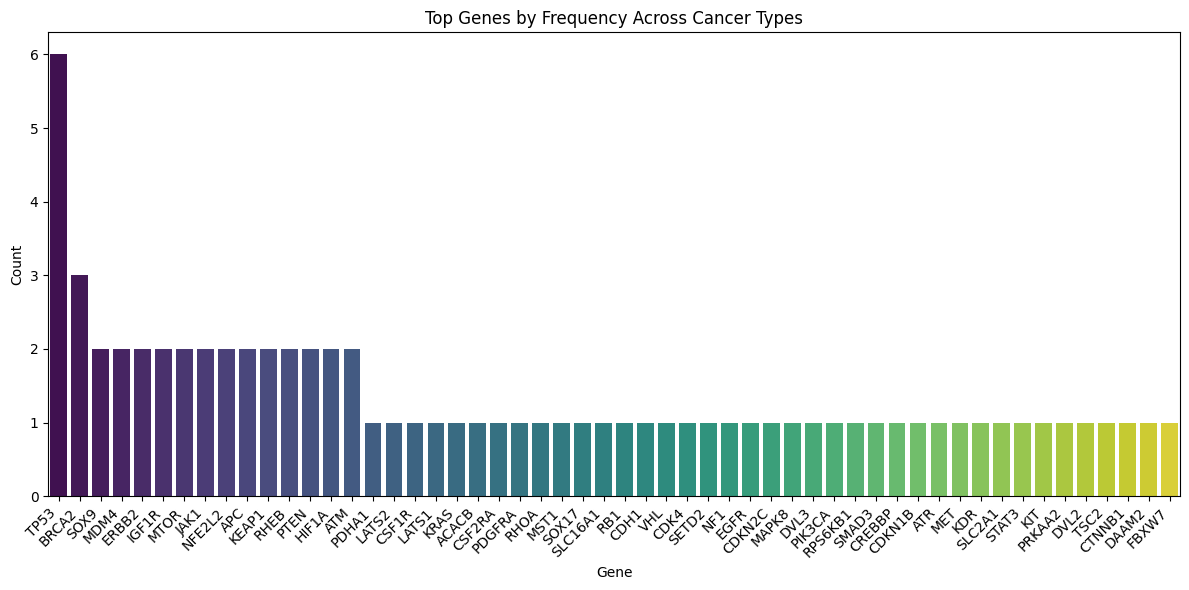

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/top5_genes_per_cancer_type.csv')

# Count how many times each gene appears as a top gene
gene_counts = df['Gene'].value_counts().reset_index()
gene_counts.columns = ['Gene', 'Count']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=gene_counts, x='Gene', y='Count', palette='viridis')
plt.title('Top Genes by Frequency Across Cancer Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
df.head()

,Cancer_Type,Gene,p-value,HR,Lower 95% CI,Upper 95% CI
0,BLCA,ERBB2,0.003773,0.443094,0.255445,0.768588
1,BLCA,KRAS,0.008605,2.280372,1.232929,4.217679
2,BLCA,IGF1R,0.021738,2.124439,1.116252,4.043211
3,BLCA,MDM4,0.032313,3.504220,1.111572,11.047023
4,BLCA,ACACB,0.032925,0.287888,0.091688,0.903924


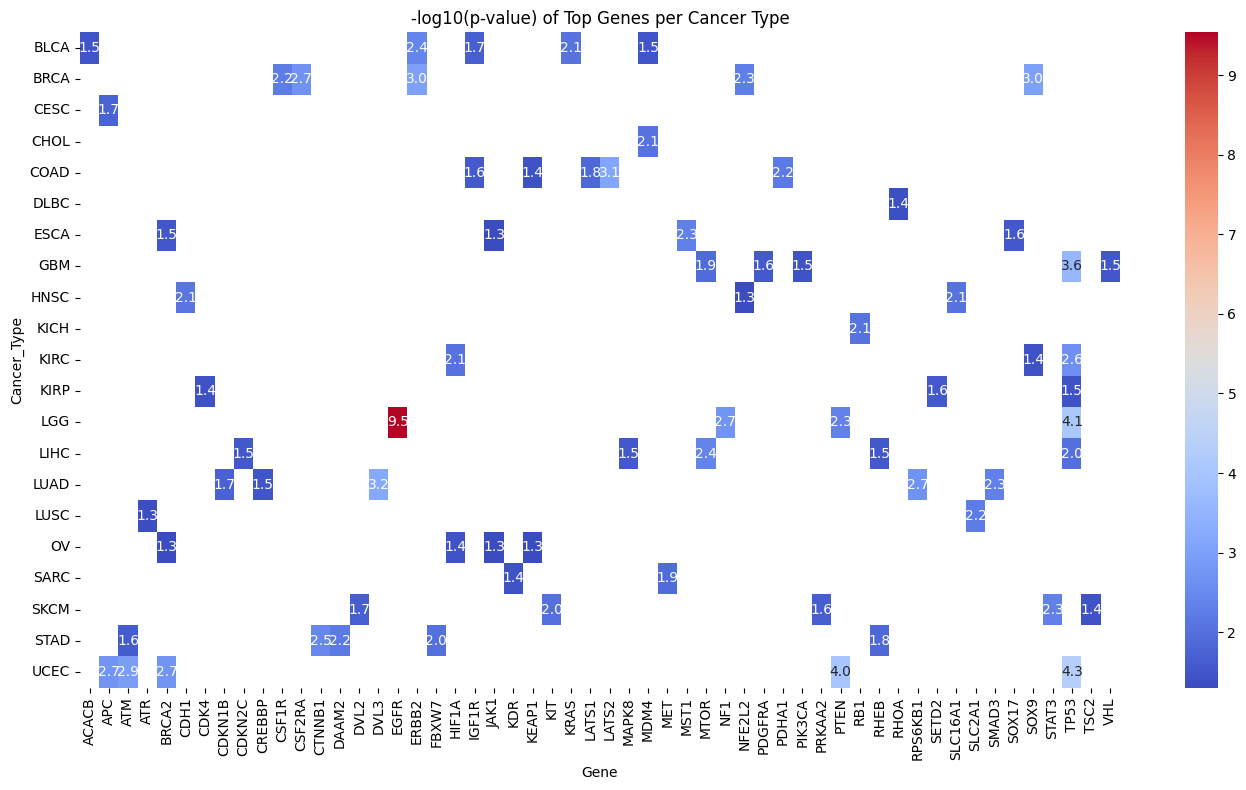

In [ ]:
import numpy as np

# Pivot table for heatmap
heatmap_df = df.pivot(index='Cancer_Type', columns='Gene', values='p-value')
heatmap_df = -np.log10(heatmap_df)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_df, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('-log10(p-value) of Top Genes per Cancer Type')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.exceptions import ConvergenceError
import os

# Load data
df = pd.read_csv('/content/sample_data/final_dataset_with_clinical (1).csv')
top_genes_df = pd.read_csv('/content/top5_genes_per_cancer_type.csv')

# Ensure alteration columns are binary
for gene in top_genes_df['Gene'].unique():
    col = gene + '_altered'
    if col not in df.columns and gene in df.columns:
        df[col] = df[gene].apply(lambda x: 1 if pd.notna(x) and str(x).strip().lower() != 'none' else 0)

# Create output directory
km_output_dir = '/content/sample_data/km_plots'
os.makedirs(km_output_dir, exist_ok=True)

cox_results = []

# Define OS columns
time_col = 'OS.time'
event_col = 'OS'

# Main analysis loop for OS only
for _, row in top_genes_df.iterrows():
    cancer = row['Cancer_Type']
    gene = row['Gene']
    altered_col = gene + '_altered'

    if altered_col not in df.columns:
        continue

    df_cancer = df[df['cancer_type'] == cancer].copy()
    if df_cancer.empty:
        continue

    sub_df = df_cancer[[altered_col, time_col, event_col]].dropna()
    if sub_df[altered_col].nunique() < 2 or sub_df[event_col].sum() == 0:
        continue

    # Kaplan-Meier plot
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8, 5))
    for group in [0, 1]:
        mask = sub_df[altered_col] == group
        label_name = f"{gene} {'Altered' if group == 1 else 'Wild-Type'}"
        kmf.fit(sub_df.loc[mask, time_col], sub_df.loc[mask, event_col], label=label_name)
        kmf.plot_survival_function(ci_show=True)

    plt.title(f"Overall Survival - {gene} in {cancer}")
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{km_output_dir}/{cancer}_{gene}_OS_KM.png")
    plt.close()

    # Cox model
    try:
        cph = CoxPHFitter()
        cph.fit(sub_df[[altered_col, time_col, event_col]], duration_col=time_col, event_col=event_col)
        summary = cph.summary.reset_index()
        summary['Cancer_Type'] = cancer
        summary['Gene'] = gene
        summary['Endpoint'] = 'OS'
        cox_results.append(summary)
    except ConvergenceError:
        print(f"⚠️ Cox model did not converge for {gene} in {cancer}")
    except Exception as e:
        print(f"❌ Error for {gene} in {cancer}: {e}")

# Save Cox results
if cox_results:
    cox_combined = pd.concat(cox_results, ignore_index=True)
    cox_combined.to_csv('cox_results_top5_OS_altered.csv', index=False)
    print("✅ OS-based Cox regression results saved to 'cox_results_top5_OS_altered.csv'")
else:
    print("⚠️ No valid Cox models were fitted for OS.")


<ipython-input-21-479e0411eff2>:8: DtypeWarning: Columns (150) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/sample_data/final_dataset_with_clinical (1).csv')


✅ OS-based Cox regression results saved to 'cox_results_top5_OS_altered.csv'


In [ ]:
import shutil

# Zip the folder
shutil.make_archive('/content/sample_data/km_plots', 'zip', '/content/sample_data/km_plots')


'/content/sample_data/km_plots.zip'

In [ ]:
from google.colab import files
files.download('/content/sample_data/km_plots')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-15-0428279438a9>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=significant_counts.values, y=significant_counts.index, palette="viridis")


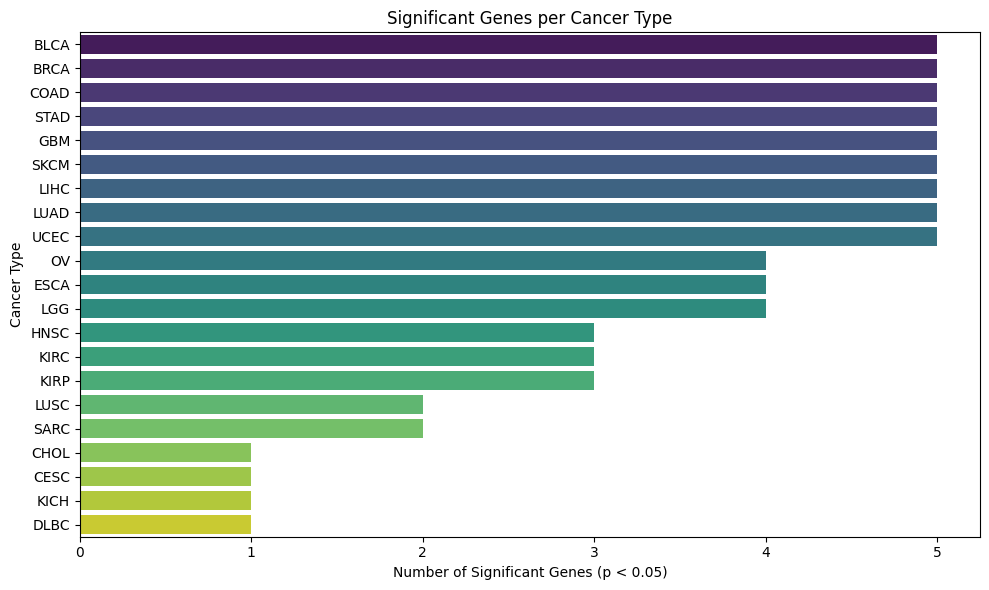

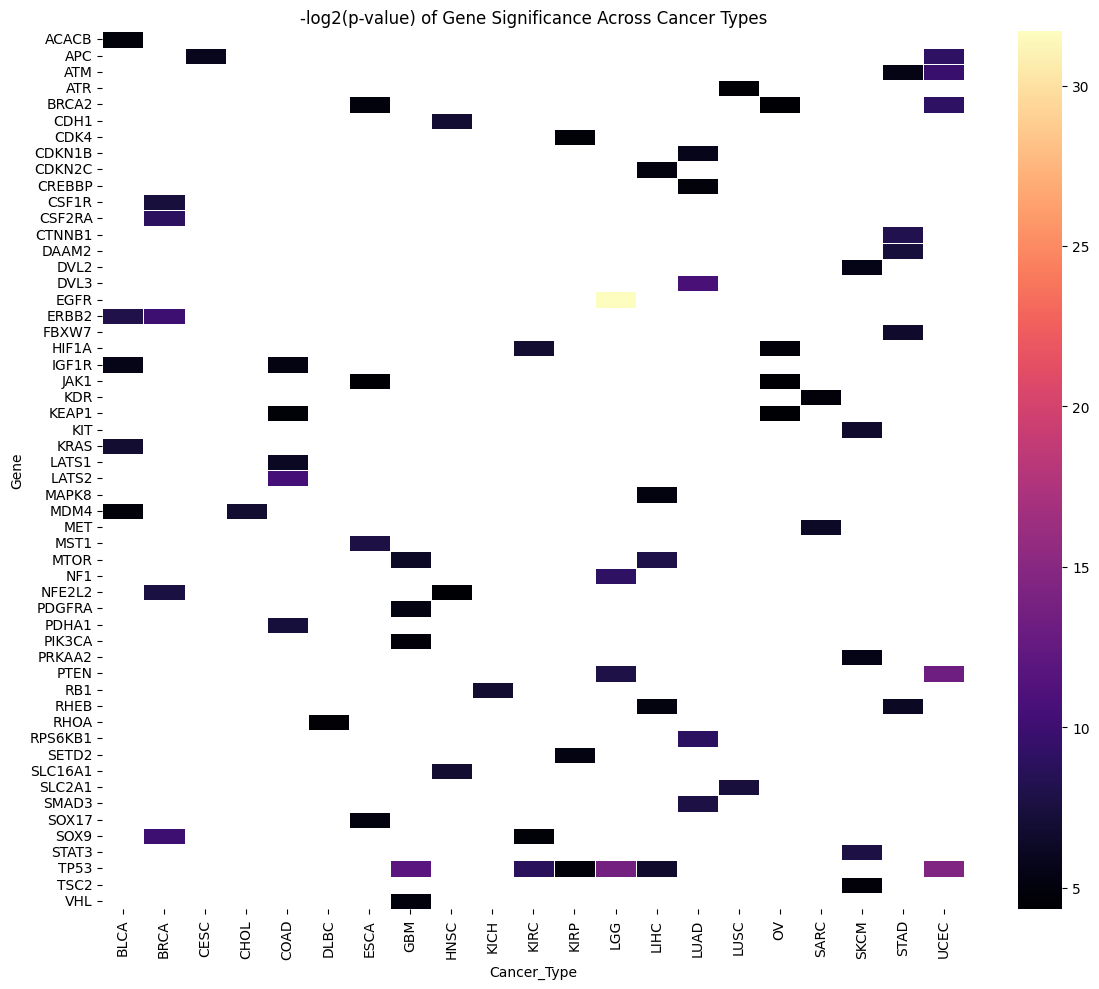

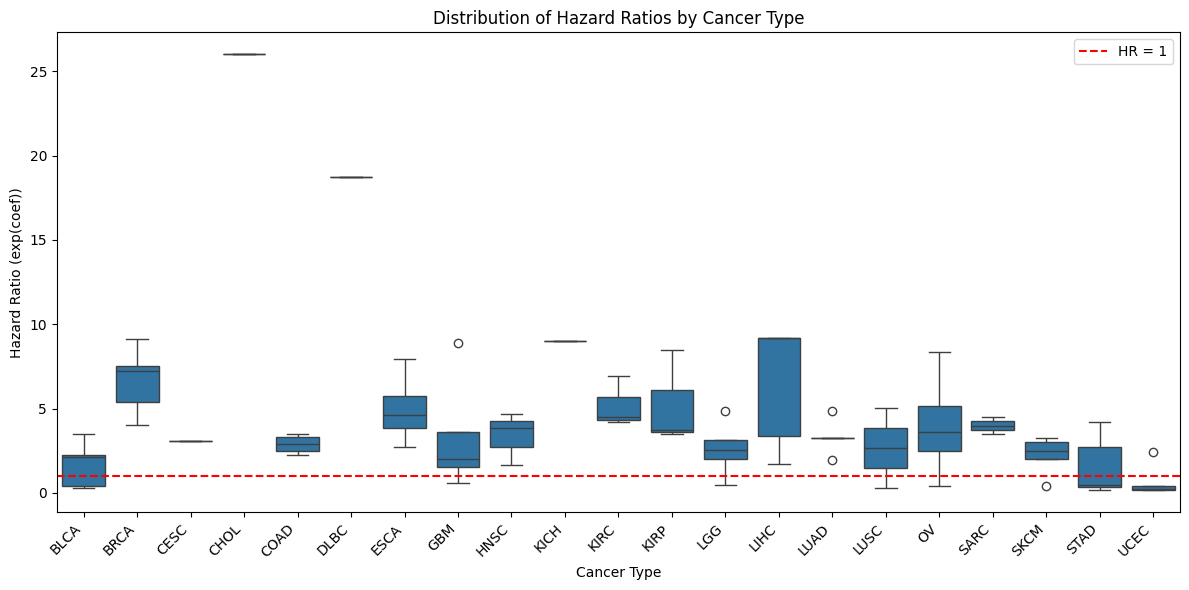

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Load Cox regression results
df = pd.read_csv("/content/cox_results_top5_OS_altered.csv")

# Convert p-values to numeric, drop invalid
df['p'] = pd.to_numeric(df['p'], errors='coerce')
df = df.dropna(subset=['p'])

# Create output directory
output_dir = "cox_summary_plots"
os.makedirs(output_dir, exist_ok=True)

# 1. Bar plot: Number of significant genes per cancer type
significant_counts = df[df['p'] < 0.05].groupby('Cancer_Type').size().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=significant_counts.values, y=significant_counts.index, palette="viridis")
plt.xlabel("Number of Significant Genes (p < 0.05)")
plt.ylabel("Cancer Type")
plt.title("Significant Genes per Cancer Type")
plt.tight_layout()
plt.savefig(f"{output_dir}/significant_genes_barplot.png")
plt.show()

# 2. Heatmap: -log2(p-value) per gene per cancer type (deduplicated)
dedup_df = df.groupby(['Gene', 'Cancer_Type'])['p'].min().reset_index()
heatmap_data = dedup_df.pivot(index='Gene', columns='Cancer_Type', values='p')
heatmap_data = -np.log2(heatmap_data)

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="magma", annot=False, linewidths=0.5)
plt.title("-log2(p-value) of Gene Significance Across Cancer Types")
plt.tight_layout()
plt.savefig(f"{output_dir}/gene_significance_heatmap.png")
plt.show()

# 3. Boxplot: Distribution of exp(coef) by cancer type
df['HR'] = np.exp(df['coef'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cancer_Type', y='HR', data=df)
plt.axhline(1, color='red', linestyle='--', label='HR = 1')
plt.ylabel("Hazard Ratio (exp(coef))")
plt.xlabel("Cancer Type")
plt.title("Distribution of Hazard Ratios by Cancer Type")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/hazard_ratios_boxplot.png")
plt.show()


In [ ]:
import pandas as pd

# Load the Cox regression results file
cox_df = pd.read_csv('/content/cox_results_top5_OS_altered.csv')

# Calculate summary statistics
total_models = len(cox_df)
significant_models = (cox_df['p'] < 0.05).sum()
highly_significant_models = (cox_df['p'] < 0.01).sum()
risky_mutations = (cox_df['exp(coef)'] > 1).sum()
protective_mutations = (cox_df['exp(coef)'] < 1).sum()

# Print the results
print(f"Total models fitted: {total_models}")
print(f"Significant models (p < 0.05): {significant_models} ({significant_models / total_models:.1%})")
print(f"Highly significant models (p < 0.01): {highly_significant_models}")
print(f"Models with HR > 1 (risky mutations): {risky_mutations}")
print(f"Models with HR < 1 (protective mutations): {protective_mutations}")


Total models fitted: 74
Significant models (p < 0.05): 74 (100.0%)
Highly significant models (p < 0.01): 36
Models with HR > 1 (risky mutations): 60
Models with HR < 1 (protective mutations): 14


In [ ]:
significant_df = pd.DataFrame(results)
significant_df.to_csv('cancer_type_specific_altered_genes.csv', index=False)


In [ ]:
import pandas as pd

df = pd.read_csv("cancer_type_specific_altered_genes.csv")
df.sort_values("p-value").head(10)

,Cancer_Type,Gene,p-value,HR,Lower 95% CI,Upper 95% CI
7,LGG,EGFR,2.884991e-10,4.875481,2.979447,7.978095
96,UCEC,TP53,4.525662e-05,2.442064,1.590132,3.750430
10,LGG,TP53,8.153601e-05,0.459096,0.311680,0.676234
93,UCEC,PTEN,1.046478e-04,0.433511,0.284192,0.661286
55,GBM,TP53,2.751832e-04,0.582133,0.434926,0.779166
48,LUAD,DVL3,6.238769e-04,3.255371,1.655473,6.401458
107,COAD,LATS2,7.728703e-04,3.289258,1.643131,6.584513
33,BRCA,SOX9,1.037893e-03,5.386850,1.969392,14.734574
28,BRCA,ERBB2,1.039137e-03,4.052895,1.756156,9.353359
76,UCEC,ATM,1.144756e-03,0.251216,0.109268,0.577567
